# Libs, cuda, seed, params

In [390]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime 

In [391]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [392]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 1
N_EPOCHS = 1000
IMG_SIZE = 32

# Data

In [393]:
def convert_img_to_gray(image, path=None):
    imgGray = image.convert('L')
    if path:
        imgGray.save(path)
    return imgGray

In [394]:
# im_in = Image.open('images/test_seven.jpg')
# im_out = Image.open('images/test_seven_2.jpg')
# im_in = convert_img_to_gray(im_in, 'images/test_seven_grey.jpg')
# im_out = convert_img_to_gray(im_out, 'images/test_seven_2_grey.jpg')

In [395]:
im_in = Image.open('images/zero.jpg')
im_out = Image.open('images/zero2.jpg')
im_in = convert_img_to_gray(im_in, 'images/zero_grey.jpg')
im_out = convert_img_to_gray(im_out, 'images/zero2_grey.jpg')

In [396]:
transformation = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=0.5, std=0.5)
])

In [397]:
# im_in = transformation(Image.open('images/test_seven_grey.jpg'))

# im_out = transformation(Image.open('images/test_seven_2_grey.jpg'))

In [398]:
# im_in = transformation(Image.open('images/zero2_grey.jpg'))


# im_out = transformation(Image.open('images/zero_grey.jpg'))

In [399]:
im_in = transformation(Image.open('images/zero_grey.jpg'))

im_out = transformation(Image.open('images/zero2_grey.jpg'))

In [400]:
print(im_in.shape)
print(im_out.shape)

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


+ In

<Figure size 432x288 with 0 Axes>

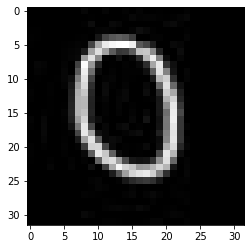

<Figure size 432x288 with 0 Axes>

In [401]:
plt.imshow(im_in.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

+ Out

<Figure size 432x288 with 0 Axes>

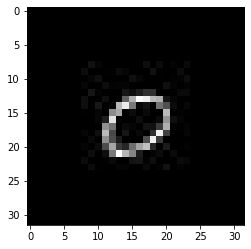

<Figure size 432x288 with 0 Axes>

In [402]:
plt.imshow(im_out.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

In [403]:
class CustomTestDataset(Dataset):
    def __init__(self, image_in, image_out):
        self.img_labels = (image_in, image_out)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img_labels[0], self.img_labels[1]

In [404]:
train_loader = DataLoader(dataset=CustomTestDataset(im_in, im_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

# Transform functions

In [405]:
def get_rot_mat(theta, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[theta_cos, -theta_sin, zeros, theta_sin, theta_cos, zeros]).view(2,3)

In [406]:
def get_scale_matrix(scale_factor, device):
    zeros = torch.zeros_like(input=scale_factor).to(device)
    return torch.stack(tensors=[scale_factor, zeros, zeros, zeros, scale_factor, zeros]).view(2,3)

In [407]:
def get_transform_matrix(theta, scale_factor, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    zeros = torch.zeros_like(input=theta_cos).to(device)
    return torch.stack(tensors=[scale_factor*theta_cos, scale_factor * (-theta_sin), zeros, scale_factor * theta_sin, scale_factor*theta_cos, zeros]).view(2,3)

In [408]:
def rot_img(x, theta, device):
    rot_mat = get_rot_mat(theta=theta, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=rot_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [409]:
def scale_img(x, scale_factor, device):
    scale_mat = get_scale_matrix(scale_factor=scale_factor, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [410]:
def scale_rot_img(x, theta, scale_factor, device):
    scale_mat = get_transform_matrix(theta = theta, scale_factor=scale_factor, device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

# Network

+ Functions

In [411]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [412]:
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [413]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=50):
    best_loss = 1e10
    train_losses = []
 
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}')
    
    return model, optimizer, train_losses

+ Model

In [414]:
class AttentionTransformation(nn.Module):

    def __init__(self, device):
        super().__init__()
        
        self.device = device
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=3)
        )

        self.angle_ff = nn.Sequential(
            nn.Linear(in_features=486, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1)
        )
        
        self.scale_ff = nn.Sequential(
            nn.Linear(in_features=486, out_features=20),
            nn.Tanh(),
            nn.Linear(in_features=20, out_features=1)
        )


    def forward(self, x_inp):
        x = self.feature_extractor(x_inp)
#         print(x.shape)
        x = torch.flatten(x, 1)
        scale_factor = self.scale_ff(x)
        theta = self.angle_ff(x)
        trans_x =scale_rot_img(x=x_inp, theta=theta, scale_factor=scale_factor, device=self.device)
        return trans_x

In [415]:
torch.manual_seed(RANDOM_SEED)
model = AttentionTransformation(device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [416]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, N_EPOCHS, device)

03:52:00 --- Epoch: 49	Train loss: 0.0140
03:52:00 --- Epoch: 99	Train loss: 0.0140
03:52:00 --- Epoch: 149	Train loss: 0.0140
03:52:01 --- Epoch: 199	Train loss: 0.0140
03:52:01 --- Epoch: 249	Train loss: 0.0140
03:52:01 --- Epoch: 299	Train loss: 0.0140
03:52:02 --- Epoch: 349	Train loss: 0.0140
03:52:02 --- Epoch: 399	Train loss: 0.0140
03:52:02 --- Epoch: 449	Train loss: 0.0140
03:52:03 --- Epoch: 499	Train loss: 0.0140
03:52:03 --- Epoch: 549	Train loss: 0.0140
03:52:03 --- Epoch: 599	Train loss: 0.0140
03:52:04 --- Epoch: 649	Train loss: 0.0140
03:52:04 --- Epoch: 699	Train loss: 0.0140
03:52:04 --- Epoch: 749	Train loss: 0.0140
03:52:05 --- Epoch: 799	Train loss: 0.0140
03:52:05 --- Epoch: 849	Train loss: 0.0140
03:52:05 --- Epoch: 899	Train loss: 0.0140
03:52:06 --- Epoch: 949	Train loss: 0.0140
03:52:06 --- Epoch: 999	Train loss: 0.0140


# Evaluation

In [417]:
with torch.no_grad():
    y = model(next(iter(train_loader))[0].to(device))

In [418]:
y.shape

torch.Size([1, 1, 32, 32])

+ What is as input:

<Figure size 432x288 with 0 Axes>

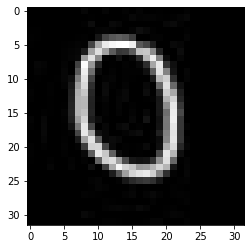

<Figure size 432x288 with 0 Axes>

In [419]:
plt.imshow(im_in.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()

+ What is doing model:

<Figure size 432x288 with 0 Axes>

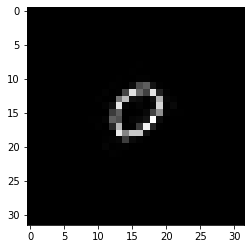

<Figure size 432x288 with 0 Axes>

In [420]:
plt.imshow(y.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
plt.figure()

+ What should do model:

<Figure size 432x288 with 0 Axes>

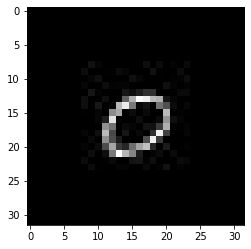

<Figure size 432x288 with 0 Axes>

In [421]:
plt.imshow(im_out.detach().cpu().permute(1,2,0), cmap='gray')
plt.figure()